<a href="https://colab.research.google.com/github/hoohahaBIGHEAD/AI/blob/main/%EB%94%B0%EB%A6%89%EC%9D%B4_%EB%8C%80%EC%97%AC%EC%88%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 라이브러리 및 데이터
##Library & Data

In [2]:
!pip install pycaret

     |████████████████████████████████| 301 kB 18.5 MB/s 
     |████████████████████████████████| 114 kB 60.1 MB/s 
     |████████████████████████████████| 167 kB 70.9 MB/s 
     |████████████████████████████████| 2.0 MB 71.0 MB/s 
     |████████████████████████████████| 15.6 MB 65.3 MB/s 
     |████████████████████████████████| 56 kB 6.5 MB/s 
     |████████████████████████████████| 86 kB 8.2 MB/s 
     |████████████████████████████████| 1.7 MB 56.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 53.1 MB/s 
     |████████████████████████████████| 1.3 MB 48.2 MB/s 
     |████████████████████████████████| 261 kB 74.2 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 3.1 MB 57.1 MB/s 
     |████████████████████████████████| 675 kB 73.2 MB/s 
     |██████████████████

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

##데이터 로딩 및 확인

In [98]:
bike_data = pd.read_csv('/content/drive/MyDrive/tmp/따릉이/train.csv')
# bike_data.drop(['id'], axis = 1, inplace=True)
test = pd.read_csv('/content/drive/MyDrive/tmp/따릉이/test.csv')
# test.drop(['id'], axis = 1, inplace=True)
submission = pd.read_csv('/content/drive/MyDrive/tmp/따릉이/submission.csv')

결측치 처리

In [99]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

it_train = bike_data.copy()
it_train = IterativeImputer(random_state=1).fit_transform(it_train)

itImp = pd.DataFrame(it_train)
itImp.columns = bike_data.columns

테스트용 결측치 처리

In [100]:
# it_test = test.copy()
# it_test = IterativeImputer(random_state=1).fit_transform(it_test)

# itImp_test = pd.DataFrame(it_test)
# itImp_test.columns = test.columns
# itImp_test.info()

In [101]:
#bike_data to itImp
#bike_data = itImp

이상치 처리

In [102]:
itImp_mid = itImp.copy()

col_name = bike_data.columns.drop(['hour_bef_precipitation'])
for iIt in col_name:
  Q1=itImp_mid[iIt].quantile(0.25)
  Q3=itImp_mid[iIt].quantile(0.75)
  IQR = Q3-Q1
  train_delout = itImp_mid[(itImp_mid[iIt]<(Q1 - 1.5*IQR)) | (itImp_mid[iIt] > (Q3 + 1.5*IQR))]
  itImp_mid = itImp_mid.drop(train_delout.index, axis = 0)

In [103]:
#bike_data = itImp_mid

더미변수 추가


In [104]:
def busyHourGen(data, col):
  lst = data[col]
  lst_ = []
  for i in lst:
    if (6 < i < 10) or (16 < i < 20):
      lst_.append(1)
    else:
      lst_.append(0)
  data['busy_hour'] = lst_
  return data

an = busyHourGen(itImp_mid, 'hour') # an = busy_hour 추가된 데이터셋

In [105]:
#bike_data = an

훈련용 검증용 변수 분리

In [106]:
from sklearn.model_selection import train_test_split


# Filter rows with missing price values
# X = an.drop(['count'], axis=1)
X = an[an.columns.difference(['count', 'hour_bef_visibility'])]
X = np.column_stack((X['hour']**5, X['hour_bef_temperature']**4, X))
y = an['count']

train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle = True, random_state=2021, test_size=0.33)

In [107]:
!pip install optuna

In [108]:
from sklearn.ensemble import ExtraTreesRegressor
from optuna.samplers import TPESampler
import optuna

def objective_extratree(trial):
  params_et = {
      "n_estimators": trial.suggest_int("n_estimators", 500, 700, step=1),
      "max_depth": trial.suggest_int("max_depth", 10, 20),
      "min_samples_split": trial.suggest_int("min_samples_split", 2, 4),
      "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 3),
      "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", 4, 5, 6]),
      "warm_start": trial.suggest_categorical("warm_start", [True, False]),
      "random_state": 2021
  }

  X = an[an.columns.difference(['count', 'hour_bef_visibility'])]
  # X = np.column_stack((X['hour']**5, X['hour_bef_temperature']**4, X))
  y = an['count']
  train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle = True, random_state=2021, test_size=0.2)

  model = ExtraTreesRegressor(**params_et)
  model.fit(train_X, train_y)

  pred = model.predict(val_X)
  rmse = np.sqrt(mean_squared_error(val_y, pred))

  return rmse

In [109]:
sampler = TPESampler(seed=2021)
study = optuna.create_study(
    study_name="et_optimizer",
    direction="minimize", 
    sampler=sampler,
    )


[I 2022-01-21 12:24:34,237] A new study created in memory with name: et_optimizer


In [110]:
study.optimize(objective_extratree, n_trials=100)

[I 2022-01-21 12:24:41,331] Trial 0 finished with value: 40.366999212472514 and parameters: {'n_estimators': 621, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'warm_start': True}. Best is trial 0 with value: 40.366999212472514.
[I 2022-01-21 12:24:42,281] Trial 1 finished with value: 40.09807204778074 and parameters: {'n_estimators': 693, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'warm_start': True}. Best is trial 1 with value: 40.09807204778074.
[I 2022-01-21 12:24:43,174] Trial 2 finished with value: 39.84898582200252 and parameters: {'n_estimators': 617, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 5, 'warm_start': False}. Best is trial 2 with value: 39.84898582200252.
[I 2022-01-21 12:24:43,967] Trial 3 finished with value: 39.75870680335304 and parameters: {'n_estimators': 560, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 5,

변수 중요도 확인

41.095272723234885


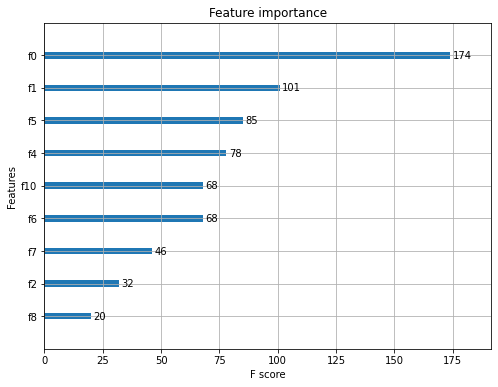

In [13]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

xgbr_all = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=1)
xgbr_all.fit(train_X, train_y)
pred = xgbr_all.predict(val_X)

rmse = np.sqrt(mean_squared_error(val_y, pred))
print(rmse)

fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgbr_all, ax=ax)

In [14]:
df_train = pd.DataFrame(itImp_mid, columns=col_name)
from pycaret.regression import *
reg = setup(df_train, target = 'count', train_size=0.8)

,Description,Value
0,session_id,7296
1,Target,count
2,Original Data,"(1307, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1045, 8)"


In [15]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,25.0994,1312.1543,36.0512,0.7781,0.5141,0.8563,0.445
lightgbm,Light Gradient Boosting Machine,25.8829,1376.7863,36.8572,0.7657,0.5599,0.9111,0.081
rf,Random Forest Regressor,26.7680,1484.6839,38.3493,0.7483,0.5345,0.9280,0.599
gbr,Gradient Boosting Regressor,27.2146,1496.8008,38.4949,0.7454,0.5574,1.0434,0.116
ada,AdaBoost Regressor,36.9585,2084.0931,45.5116,0.6435,0.7520,1.5425,0.099
lasso,Lasso Regression,37.7846,2471.0981,49.5601,0.5804,0.7797,1.4703,0.012
ridge,Ridge Regression,37.7875,2470.9951,49.5605,0.5803,0.7778,1.4769,0.010
lar,Least Angle Regression,37.8065,2471.8172,49.5645,0.5801,0.7760,1.4806,0.011
lr,Linear Regression,37.8065,2471.8180,49.5645,0.5801,0.7760,1.4806,0.238
br,Bayesian Ridge,37.7940,2471.6270,49.5646,0.5803,0.7806,1.4690,0.011


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

bike_data[ hour ]의 왜도:  0.003659038646423124
bike_data[ hour_bef_temperature ]의 왜도:  0.17522408110232682
bike_data[ hour_bef_precipitation ]의 왜도:  5.363369262328469
bike_data[ hour_bef_windspeed ]의 왜도:  0.559761388501819


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

bike_data[ hour_bef_humidity ]의 왜도:  0.14944445493832664
bike_data[ hour_bef_visibility ]의 왜도:  -0.4842749631294303
bike_data[ hour_bef_ozone ]의 왜도:  0.39730312582811467
bike_data[ hour_bef_pm10 ]의 왜도:  2.3854639567027447
bike_data[ hour_bef_pm2.5 ]의 왜도:  1.3566878820269048
bike_data[ count ]의 왜도:  0.9125336769560027


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


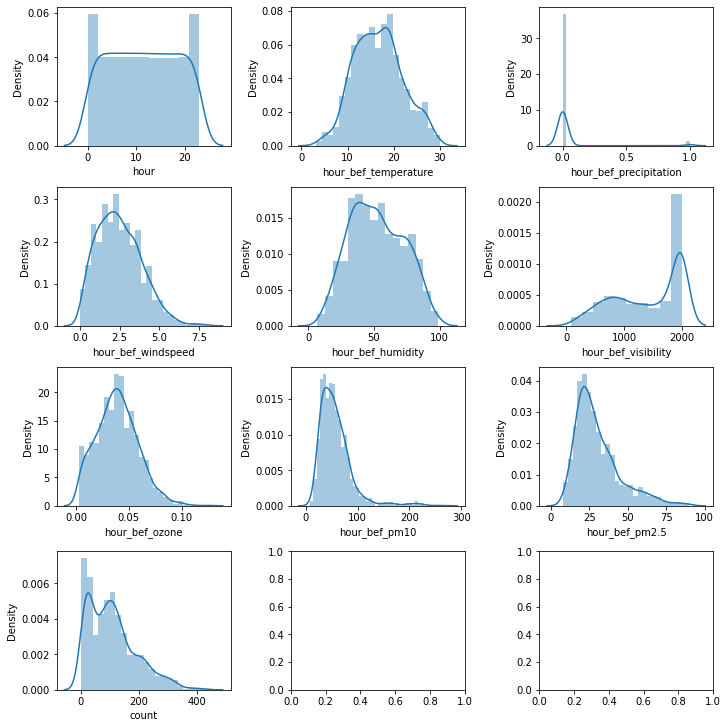

In [108]:


#bike_data['hour_bef_ozone'] = np.log(bike_data['hour_bef_ozone']+1)
#bike_data['hour_bef_pm10'] = np.log(bike_data['hour_bef_pm10']+1)
#bike_data['hour_bef_pm2.5'] = np.log(bike_data['hour_bef_pm2.5']+1)
 #= bike_data[['hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']].apply(lambda x: np.log(x+1))

f, axes = plt.subplots(4, 3, figsize = (10, 10), constrained_layout=True)
for i, feature in enumerate(bike_data.columns):
  sns.distplot(bike_data[feature], ax = axes[i//3, i%3])
  print("bike_data[", feature, "]의 왜도: ", bike_data[feature].skew())

plt.show()

# fb = fb[['hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']].apply(lambda x: np.log(x+1))

##val data 분리

In [109]:
from sklearn.model_selection import train_test_split

# Filter rows with missing price values
filtered_bike_data = bike_data.dropna(axis=0)
X = filtered_bike_data.drop(['count'], axis=1)
y = filtered_bike_data['count']

train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle = True, random_state=1, test_size=0.2)

(266,)


490     101.0
771     189.0
1084     26.0
123     194.0
1269     12.0
        ...  
8        39.0
262      44.0
1247    165.0
529      15.0
714      22.0
Name: count, Length: 266, dtype: float64

#2. 탐색적 자료분석(EDA)
##기존 데이터 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1459 non-null   int64  
 1   hour_bef_temperature    1457 non-null   float64
 2   hour_bef_precipitation  1457 non-null   float64
 3   hour_bef_windspeed      1450 non-null   float64
 4   hour_bef_humidity       1457 non-null   float64
 5   hour_bef_visibility     1457 non-null   float64
 6   hour_bef_ozone          1383 non-null   float64
 7   hour_bef_pm10           1369 non-null   float64
 8   hour_bef_pm2.5          1342 non-null   float64
 9   count                   1459 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 114.1 KB


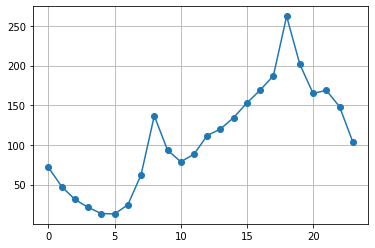

In [110]:
import matplotlib.pyplot as plt

bike_data.isna().sum()
bike_data.info()
#bike_data.groupby('hour').mean()['hour_bef_windspeed'].plot()
#bike_data[bike_data['hour_bef_temperature'].isna()]
# hour 기준으로 평균을 내고 카운트를 출력
#bike_data.groupby('hour').mean()['count'].plot()
plt.plot(bike_data.groupby('hour').mean()['count'], 'o-')
plt.grid()

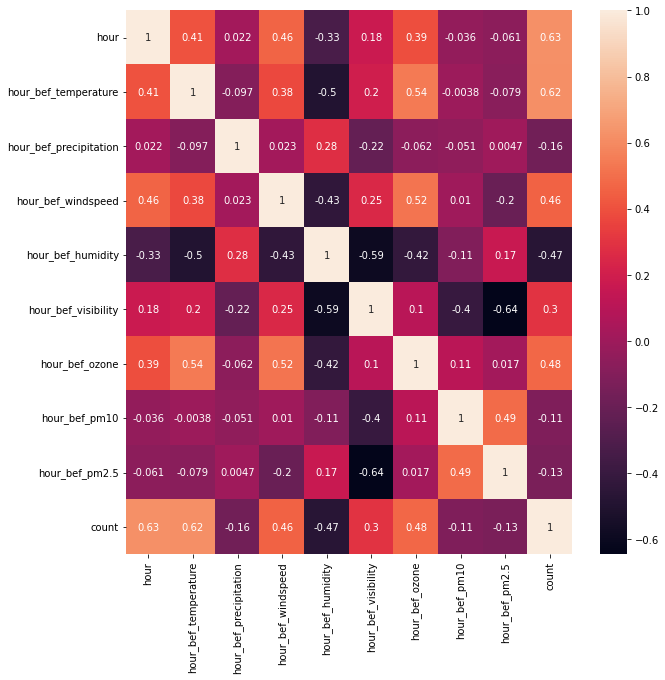

In [111]:
#print(bike_data.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(bike_data.corr(), annot=True)

##모델 정의 및 학습

In [112]:
added_test = busyHourGen(itImp_test, 'hour') # added_test = busy_hour 추가된 데이터셋
added_test.describe()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,busy_hour
count,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000
mean,11.472727,23.266099,0.051822,2.389401,56.657451,1359.709018,0.040762,36.808377,24.856956,0.248951
std,6.928427,4.037507,0.221665,1.170689,19.650157,613.768457,0.020301,12.402226,9.917683,0.432708
min,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000,0.000000
25%,5.500000,20.300000,0.000000,1.500000,42.000000,808.500000,0.027000,28.000000,17.000000,0.000000
50%,11.000000,22.900000,0.000000,2.300000,55.000000,1497.000000,0.038000,35.000000,24.000000,0.000000
75%,17.000000,26.350000,0.000000,3.250000,73.500000,2000.000000,0.051500,44.000000,31.000000,0.000000
max,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000,1.000000


In [113]:
model = RandomForestRegressor()
#model.fit(train_X, train_y)
model.fit(X, y)
test.fillna(0,inplace = True)


pred = model.predict(test)

#submission['count'] = pred
submission.to_csv('베이스라인_테스트만0.csv',index = False)
# plt.scatter(val_y, pred)
# plt.show()
# #print(pred)
# print(mean_squared_error(val_y, pred)**0.5)

##DNN을 위한 데이터 정규화

In [526]:
# cnn을 위한 데이터 정규화
# min_X = train_X.min()
# max_X = train_X.max()
# min_y = train_y.min()
# max_y = train_y.max()
# train_X = (train_X - min_X) / (max_X - min_X)
# train_y = (train_y - min_y) / (max_y - min_y)

print(train_X[:5])
print(val_X[:5])
print(train_y[:5])
print(val_y[:5])

min_X = train_X.min()
max_X = train_X.max()
def normalize_X(X):
  return (X - min_X) / (max_X - min_X)

min_y = train_y.min()
max_y = train_y.max()
def normalize_y(y):
  return (y - min_y) / (max_y - min_y)

def denormalize_y(y):
  return (max_y - min_y) * y + min_y

norm_train_X = normalize_X(train_X)
norm_val_X = normalize_X(val_X)
norm_train_y = normalize_y(train_y)
norm_val_y = normalize_y(val_y)

print(norm_train_X[:5])
print(norm_val_X[:5])
print(norm_train_y[:5])
print(norm_val_y[:5])

      hour  hour_bef_temperature  ...  hour_bef_pm2.5  busy_hour
832   18.0                  14.2  ...        3.951244          1
1286  15.0                  22.2  ...        2.397895          0
561    8.0                  18.0  ...        3.367296          1
566   12.0                  16.2  ...        3.677148          0
173   14.0                  18.8  ...        2.708050          0

[5 rows x 10 columns]
      hour  hour_bef_temperature  ...  hour_bef_pm2.5  busy_hour
729   17.0                  23.5  ...        3.433987          1
1156   1.0                  17.3  ...        3.771288          0
184    4.0                  10.1  ...        3.135494          0
1128  18.0                  18.8  ...        3.828641          1
1267   7.0                  16.0  ...        2.944439          1

[5 rows x 10 columns]
832     113.0
1286    152.0
561      57.0
566     108.0
173     113.0
Name: count, dtype: float64
729     257.0
1156     84.0
184      12.0
1128    279.0
1267    117.0
Name: 

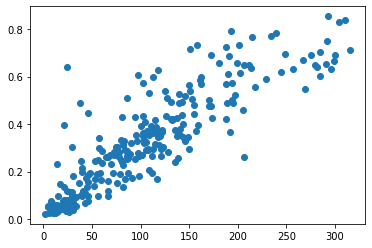

36.46211993393056


In [527]:
model = RandomForestRegressor()
model.fit(norm_train_X, norm_train_y)
pred = model.predict(norm_val_X)
denorm_pred = denormalize_y(pred)

plt.scatter(val_y, pred)
plt.show()
#print(pred)
print(mean_squared_error(val_y, denorm_pred)**0.5)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 1000)              10000     
                                                                 
 dense_97 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_98 (Dense)            (None, 100)               100100    
                                                                 
 dense_99 (Dense)            (None, 100)               10100     
                                                                 
 dense_100 (Dense)           (None, 10)                1010      
                                                                 
 dense_101 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1,122,221
Trainable params: 1,122,221
N

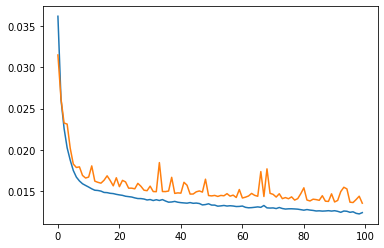

9/9 [==============================] - 0s 3ms/step - loss: 0.0110 - mape: 97.9468
loss= 0.01102351862937212
mape= 97.94684600830078


In [148]:
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense

model = keras.Sequential()
model.add(Dense(1000, activation='relu', input_shape=(9,)))
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(optimizer="SGD", loss="mse", metrics=["mape"])
model.summary()

history = model.fit(norm_train_X, norm_train_y, epochs=100, verbose=1, batch_size=16, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

loss, mape = model.evaluate(norm_val_X, norm_val_y)
print("loss=", loss)
print("mape=", mape)

##학습된 모델로 예측 데이터 생성

In [150]:
from sklearn.metrics import mean_squared_error

pred = model.predict(norm_val_X)

In [151]:
denorm_pred = denormalize_y(pred)
print(denorm_pred[:5])
#denorm_norm_val_y = denormalize_y(norm_val_y)
#print(denorm_norm_val_y[:5])


[[151.35376 ]
 [ 67.75154 ]
 [ 34.076935]
 [150.14421 ]
 [ 47.10838 ]]


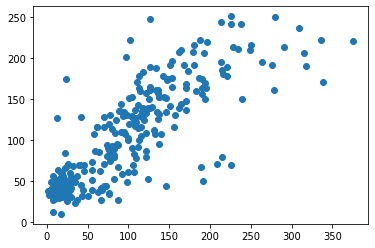

45.146966450976656


In [152]:
plt.scatter(val_y, denorm_pred)
plt.show()
#print(pred)
print(mean_squared_error(val_y, denorm_pred)**0.5)

ValueError: ignored